In [1]:
!pip install slycot

     |████████████████████████████████| 1.5 MB 22.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1418255 sha256=e3207f8993859f21ebd394d4ea9884f8c939bf6bde5cc65ce86392f06428225c
  Stored in directory: /root/.cache/pip/wheels/fa/b2/19/1e6568896fbabaf2a03d2fb6575211d281afcb9e00ce026cf6
Successfully built slycot


In [2]:
!pip install control


     |████████████████████████████████| 357 kB 13.7 MB/s 
  Created wheel for control: filename=control-0.9.1-py2.py3-none-any.whl size=364703 sha256=ea4876bdaff0d9c50f9f7a02db122e1e4a60fb6fa825c958b4d0a1990e5f0c59
  Stored in directory: /root/.cache/pip/wheels/b1/50/22/8005107713828997d1af664fbd629c7f935a1b87fc2f4ba6c1
Successfully built control


In [3]:

from __future__ import division
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import control
import control.matlab as mlab
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg as sla
import scipy.integrate as integrate
import scipy as spy
from sympy import Matrix
import numpy.linalg as nla
import matplotlib as mpl
#from _547utils import *
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=10)
lw=4
fs=20

In [4]:
def feuler(f, T=None ,x0=[], dt=1e-3,MAXITERS=None, t0=0):
    '''
        T  :  final time
        f  :  dynamics, (t,x) --> R^n
        x  :  state, in R^n
        dt :  stepsize
        x0 :  initial state, in R^n
        
        (optional)
        MAXITERS : if you want to specify iterations, you can
        t0 : initial time
    '''
    n=len(x0)
    if T==None and MAXITERS!=None:
        T=MAXITERS*dt
    elif MAXITERS==None and T!=None:
        MAXITERS=int(T/dt)
    else:
        raise Exception('MAXITERS or T should be defined.')


    x=[x0]
    t=[t0]
    for i in range(MAXITERS-1):
        x.append(x[-1]+dt*f(t[-1],x[-1]))
        t.append(t[-1]+dt)
    return np.asarray(t),np.asarray(x).reshape(MAXITERS,n)

Consider controlling a satellite in circular orbit. The satellite is of
mass $m$ with thrust in the radial direction $u_1$ and in the tangential
direction $u_2$. In cylindrical coordinates the dynamics are
\begin{eqnarray*}
    m(\ddot{r}-r\dot{\theta}^2)&=& u_1-\frac{km}{r^2}\\
    m(2\dot{r}\dot{\theta}+r\ddot{\theta})&=& u_2
\end{eqnarray*}


  - a. What is the state space representation of this system?
  - b. Find the equilibria (i.e., where $\ddot{r}=\ddot{\theta}=0$) when $u_1=0=u_2$. Linearize about the equilibrium where $\dot{r}=0$.
  - c. Given $m=100$kg, an equilibrium radius $6.37\times 10^3+300$km (first term is the radius of the earth) and $k=GM$ where $G=6.673\times 10^{-11}$ is the universal gravitational constant and $M=5.98\times 10^{24}$ is the mass of the earth, find the solution to the minimum norm control plus state LQR problem with $R=\rho I$ where $\rho=1e6$ and $Q=I$. submit your Python notebook. Plot the state trajectories of the system and the control input overtime.

With $\ddot{r}=\ddot{\theta}=0$ and $u_i=0$, to find an
equilibrium we need to solve
$$x_1x_4^2-\frac{k}{x_1}=0, \ -2x_3\frac{x_4}{x_1}=0$$
Doing so gives us that $x_3=\dot{r}$ and or $x_4=\dot{\theta}=0$. Let
$x_3=0$ so that $x_1=\tilde{r}$ is some constant and
$$x_4=\dot{\theta}=\sqrt{\frac{k}{x_1^3}}=\tilde{\omega}\ \implies\
k=\tilde{r}^3\tilde{\omega}^2$$
and $x_2=\theta=\tilde{\omega}t$. 

Linearizing we have that
        $$\tilde{x}(t)=\begin{bmatrix}{\tilde{r}\\ \tilde{\omega}t\\ 0\\ \tilde{\omega}}\end{bmatrix}$$ so that
$$\dot{\tilde{x}}=\begin{bmatrix} 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 1\\\frac{2k}{\tilde{r}^3}+\tilde{\omega}^2 & 0 & 0&2\tilde{r}\tilde{\omega}\\0 & 0 & -2\frac{\tilde{\omega}}{\tilde{r}} & 0 \end{bmatrix} =\begin{bmatrix}0 & 0 & 1 & 0\\ 0 & 0& 0& 1\\ 3\tilde{\omega}^2 & 0 & 0 &  2\tilde{r}\tilde{\omega}\\ 0 & 0 & -2\frac{\tilde{\omega}}{\tilde{r}} & 0\end{bmatrix}\tilde{x}+\begin{bmatrix} 0 & 0\\ 0& 0\\ \frac{1}{m} & 0\\ 0 & \frac{1}{m\tilde{r}}\end{bmatrix}\begin{bmatrix}u_1\\ u_2\end{bmatrix}$$
If we looking at the satellite (from the earth) we can say that we can
observe $r$ and $\dot{\theta}$ (distance and angular speed) so that
$$y=\begin{bmatrix}1 & 0 & 0 &0\\ 0 & 0& 0& 1\end{bmatrix}\tilde{x}$$


In [5]:
m=100
r=300e3
print(r)
rB=6.37e6
print(rB)
M=5.98e24
G=6.673*10**(-11)
print(G)
k=G*M
#k=3.9905e14
print(k)
print(3.9905e14)
rho=1e6
R=rho*np.eye(2)
Q=np.eye(4)
omega=np.sqrt(k/((rB+r)**3))
print(omega)
A=np.array([[0, 0, 1, 0],
           [0, 0, 0, 1],
           [3*omega**2, 0, 0, 2*(r+rB)*omega],
           [0, 0, -2*omega/(r+rB), 0]])

C=np.array([[1, 0, 0, 0],[0,0,0,1]])
B=np.array([[0,0],[0,0],[1/m,0],[0,1/(m*r)]])
B1=np.array([[0],[0],[0],[1/(m*r)]])
print("A :\n", A)
print("C :\n", C)
print("B :\n", B)
print("spec(A): \n", np.linalg.eig(A)[0])

300000.0
6370000.0
6.673e-11
399045400000000.0
399050000000000.0
0.0011596379073433338
A :
 [[ 0.0000000000e+00  0.0000000000e+00  1.0000000000e+00  0.0000000000e+00]
 [ 0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  1.0000000000e+00]
 [ 4.0342802284e-06  0.0000000000e+00  0.0000000000e+00  1.5469569684e+04]
 [ 0.0000000000e+00  0.0000000000e+00 -3.4771751345e-10  0.0000000000e+00]]
C :
 [[1 0 0 0]
 [0 0 0 1]]
B :
 [[0.0000000000e+00 0.0000000000e+00]
 [0.0000000000e+00 0.0000000000e+00]
 [1.0000000000e-02 0.0000000000e+00]
 [0.0000000000e+00 3.3333333333e-08]]
spec(A): 
 [ 0.0000000000e+00+0.j           -8.5533437307e-58+0.j
  2.7105054312e-20+0.0011596379j  2.7105054312e-20-0.0011596379j]


In [6]:
def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller.
 
    dx/dt = A x + B u
 
    cost = integral x.T*Q*x + u.T*R*u
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(spy.linalg.solve_continuous_are(A, B, Q, R))
 
    #compute the LQR gain
    K = np.matrix(spy.linalg.inv(R)@(B.T@X))
 
    eigVals, eigVecs = spy.linalg.eig(A-B@K)
 
    return K, X, eigVals

K,P,e=lqr(A,B,Q,R)
Acl=A-B@K
print('eig(Acl):', e)
print("")
print('feedback gain: ', K)

eig(Acl): [-7.9308404124e-03+0.j           -4.0140252923e-03+0.0069932985j
 -4.0140252923e-03-0.0069932985j -6.9705277649e-10+0.j          ]

feedback gain:  [[ 3.1721856563e-04 -9.9679895233e-04  5.5174010085e-02  7.0666492548e+04]
 [ 1.0748591066e-03 -7.9947360358e-05  2.3555497516e-01  4.6221454780e+05]]


In [7]:
n=4
f=lambda t,x: Acl@x
x0=np.random.rand(n)
x0=np.array([1,1,1,1]).reshape(n,1)
t,x=feuler(f,T=1001,t0=0,x0=x0,MAXITERS=None, dt=1e-2)

In [8]:
B@K

matrix([[ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00],
        [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00],
        [ 3.1721856563e-06, -9.9679895233e-06,  5.5174010085e-04,
          7.0666492548e+02],
        [ 3.5828636888e-11, -2.6649120119e-12,  7.8518325054e-09,
          1.5407151593e-02]])

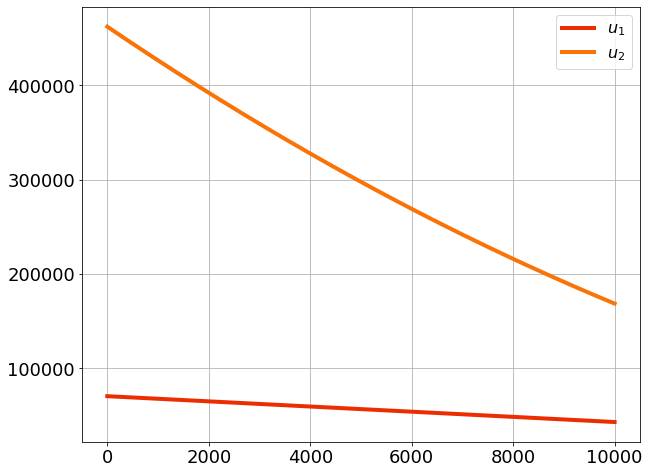

In [11]:
# plot all together
plt.figure(figsize=(10,8))
colors=['xkcd:tomato red', 'xkcd:orange','xkcd:golden rod','xkcd:bright blue']
u=[]
for i in range(10001):
    u.append(K@x[i,:])
u=np.asarray(u)
u=u.reshape(10001,2)
for i in range(0,2):
    plt.plot(u[:,i], label=r'$u_{}$'.format(str(i+1)),linewidth=4, color=colors[i])
plt.legend(fontsize=16)
plt.tick_params(labelsize=18)
plt.grid(True)

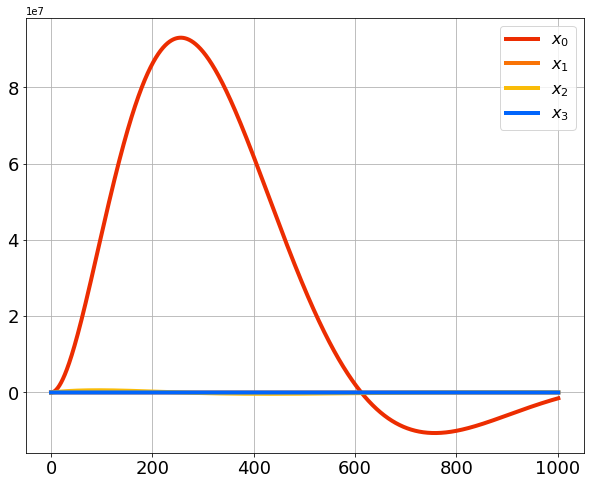

In [12]:
# plot all together
plt.figure(figsize=(10,8))
colors=['xkcd:tomato red', 'xkcd:orange','xkcd:golden rod','xkcd:bright blue']
for i in range(0,n):
    plt.plot(t,x[:,i], label=r'$x_{}$'.format(str(i)),linewidth=4, color=colors[i])
plt.legend(fontsize=16)
plt.tick_params(labelsize=18)
plt.grid(True)

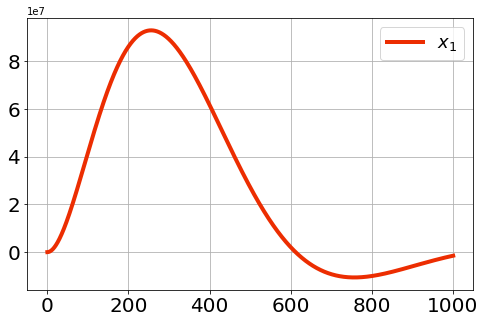

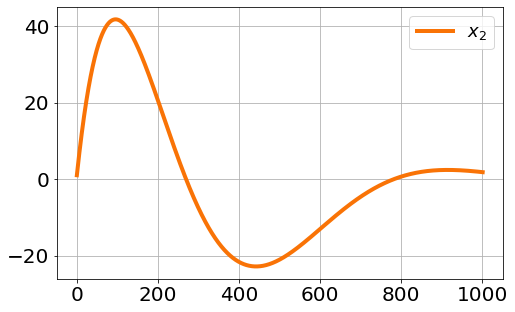

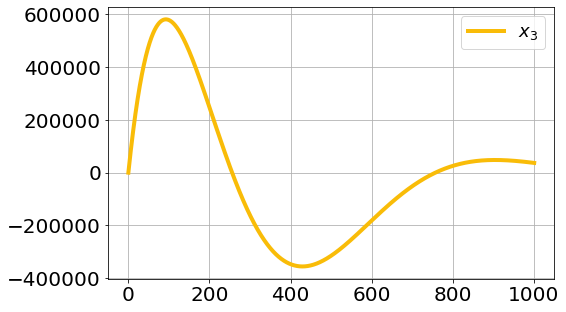

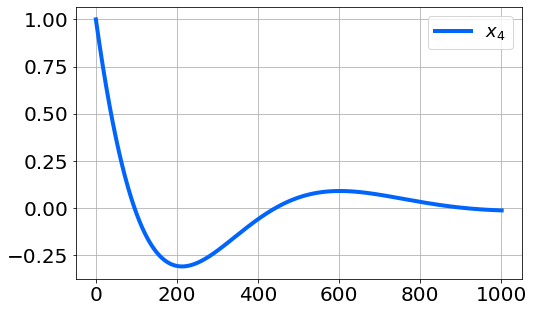

In [14]:
# plot separately so we can see the beahvior
for i in range(4):
    plt.figure(figsize=(8,5))
    plt.plot(t,x[:,i], color=colors[i], linewidth=4, label=r'$x_{}$'.format(str(i+1)))
    plt.grid(True)
    plt.tick_params(labelsize=20)
    plt.legend(fontsize=18)


## Let's see if its the same as scipy's ode solver

In [ ]:
def cllp(x,t):
    return np.asarray(Acl@x).reshape(4,)
x0=np.array([1,1,1,1])
from scipy.integrate import odeint
t = np.linspace(0, 1000, 1001)
sol = odeint(cllp, x0, t)

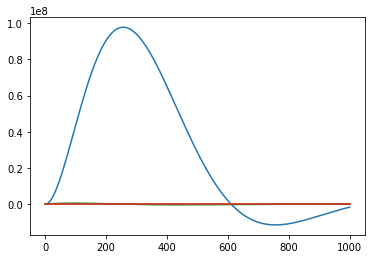

In [ ]:
# plot all together
plt.plot(t,sol)

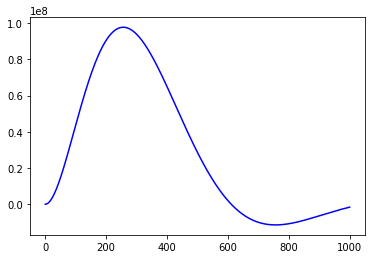

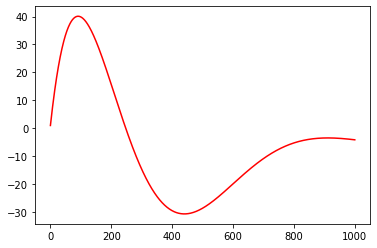

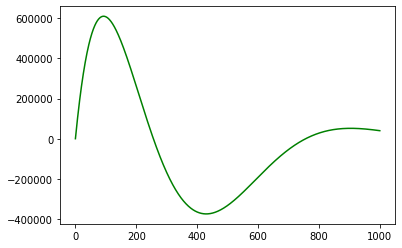

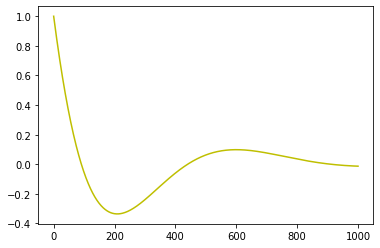

In [ ]:
plt.plot(t,sol[:,0], color='b')
plt.figure()
plt.plot(t,sol[:,1], color='r')
plt.figure()
plt.plot(t,sol[:,2], color='g')
plt.figure()
plt.plot(t,sol[:,3], color='y')